## EE257 HW#3 HELP 

In [6]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
#plt.style.use('seaborn-white')

In [5]:
df = pd.read_csv('Default.csv', index_col = 0)

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head()

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.62507,0,0
2,No,Yes,817.180407,12106.13470,0,1
3,No,No,1073.549164,31767.13895,0,0
4,No,No,529.250605,35704.49394,0,0
5,No,No,785.655883,38463.49588,0,0


## Figure 4.1

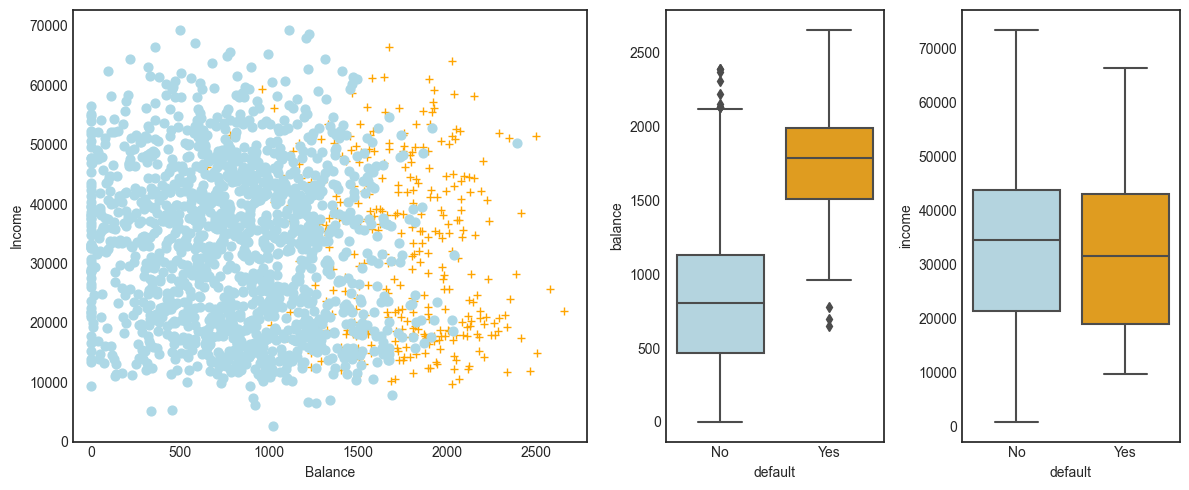

In [3]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]

df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, c='lightblue', marker='o',
            linewidths=1)


ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot(x = 'default', y = 'balance', data=df,  orient='v', ax=ax2, palette=c_palette)
sns.boxplot(x = 'default', y = 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())


## Logistic Regression

In [4]:
## Using sklearn 

y = df.default2
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65133019]


In [5]:
# statmodels
est = smf.logit("default2 ~ balance", data = df).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [6]:
est = smf.logit("default2 ~ student2", data = df).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


## Multiple Logistic Regression

In [7]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.logit("default2 ~ balance + income + student2", data = df).fit()
est.summary2().tables[1]
y_pred_prob = est.predict(X_train)
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred)

df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


## LDA

In [9]:
X = df[['balance', 'income', 'student2']]
y = df.default2

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)
confusion_matrix(y, y_pred)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [10]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))


              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



In [11]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
False,9435,140
True,232,193


In [12]:
# set up input arrays for err_analysis functionfrom sklearn.discriminant_analysis import LinearDiscriminantAnalysis20
#from sklearn.qda import QDA
#from sklearn.linear_model  import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier